## Sedaro Validaton Notebook
### Relative Motion

This notebook exercises relative motion calculations across distributed agents. The Sedaro computation model is unique in that it allows distributed processing of simulated agents spread across many processes, cores, and virtual machines. Distributed processing can impact the ability of agents within the simulation to get timely information about other participants. Sedaro overcomes this difficulty with interpolation and extrapolation from available data. In general, the distributed-agent relative motion error is driven by the relative velocity between the two agents and a smaller time step on the target produces smaller error. This notebook demonstrates that one can drive down relative motion knowledge error by constraining the time steps of participating agents.

Users can control the time step used for simulations through the `timeStepConstraint` field on the root of templated and peripheral agents. Here, we set the maximum time step to 0.1s for all agents in the scenario.

Future versions of Sedaro will include more sophisticated interpolation and extrapolation methods that can provide better precision with larger time steps.

### Reproducing our Results

To ensure reproducibility, the directory containing this notebook also includes a `requirements.txt` file that specifies the exact package versions that were used. To create a similar environment, use the following sequence of commands with Python `3.11` and the built-in `venv` package. See the [venv documentation](https://docs.python.org/3/library/venv.html) for more details on how this works.

- In a unix-like terminal:

    ```zsh
    > python -m venv .venv
    > source .venv/bin/activate
    > pip install -r requirements.txt
    ```

- In a Windows `cmd.exe` terminal:
    ```bat
    C:\> python -m venv .venv
    C:\> .venv\Scripts\activate.bat
    C:\> pip install -r requirements.txt
    ```

- In Windows PowerShell:

    ```bat
    C:\> python -m venv .venv
    C:\> .venv\Scripts\Activate.ps1
    C:\> pip install -r requirements.txt
    ```

Confirm that the Jupyter notebook is using this virtual evironment before running the code below.

In [114]:
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
from sedaro import SedaroApiClient

### Important: Read Before Running

This notebook requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

In [115]:
with open('../../secrets.json', 'r') as file:
    API_KEY = json.load(file)['API_KEY']

## Download Scenario Data

This notebook considers the following reference scenario(s):
- [Relative Motion Validation](https://satellite.sedaro.com/scenario/PM82GkkThT9BfXFCK5Wylp/edit)

In [116]:
SCENARIO_BRANCH_ID = 'PM82GkkThT9BfXFCK5Wylp'

sedaro = SedaroApiClient(API_KEY)
sim = sedaro.scenario(SCENARIO_BRANCH_ID).simulation

In [117]:
# Get results
results = sim.results()
results.summarize()

Downloading...: 100%|██████████[00:11<00:00]

---------------------------------------------------------------------------
                      Sedaro Simulation Result Summary                     
---------------------------------------------------------------------------
✅ Simulation succeeded after 273.2s

🛰️ Templated Agents 
    • LEO Observer
    • MEO Observer
    • GEO Observer
    • Ground Observer

📡 Peripheral Agents 
    • LEO Target
    • MEO Target
    • GEO Target
    • Ground Target
---------------------------------------------------------------------------
❓ Query agent results with .agent(<NAME>)


## Compare Results

Compares `range` as calculated by an agent at a particular time step to the true range calculated from the position of the target and the agent. To ensure alignment of data, all results are interpolated using `scipy`.

In [118]:
def plot_range_error(results, observer_name, target_name, target_block, points=1000):
    '''Plots the range error between an observer and a target over time.
    
    Interpolates both target and observer positions to calculate the true range
    and compares it to the range calculated by the observer during the simulation.
    '''
    target_position = results.agent(target_name).block('root').position.eci
    target_interpolant = interp1d(target_position.mjd, np.asarray(target_position.values).T)

    observer_position = results.agent(observer_name).block('root').position.eci
    observer_interpolant = interp1d(observer_position.mjd, np.asarray(observer_position.values).T)

    target_range = results.agent(observer_name).block(target_block).range.km
    range_interpolant = interp1d(target_range.mjd, np.asarray(target_range.values).T)

    def range_(epoch):
        return np.linalg.norm(target_interpolant(epoch) - observer_interpolant(epoch))

    start = max(observer_position.mjd[0], target_position.mjd[0])
    end = min(observer_position.mjd[-1], target_position.mjd[-1])
    epochs = np.linspace(start, end, points)
    elapsed_times = [(epoch - start) * 86400 for epoch in epochs]
    error = [1e3 * (range_(epoch) - range_interpolant(epoch)) for epoch in epochs]

    plt.plot(elapsed_times, error, linewidth=1, c='black')
    plt.title(f'Range Error: {observer_name} $\\rightarrow$ {target_name}')
    plt.xlabel('Elapsed Time (s)')
    plt.ylabel('Range Error (m)')
    plt.show()

### LEO Observer

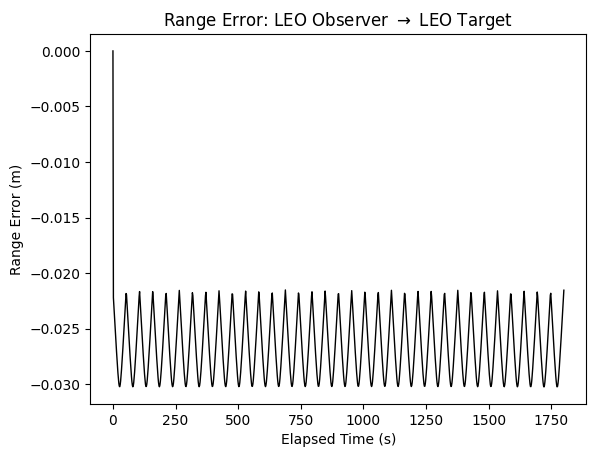

In [119]:
plot_range_error(results, 'LEO Observer', 'LEO Target', 'PMH8sdZ9PY4DmmRWwtvghy')

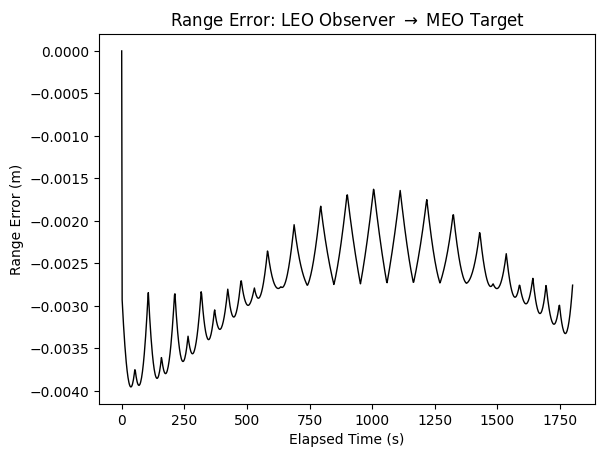

In [120]:
plot_range_error(results, 'LEO Observer', 'MEO Target', 'PMH8skzKNF6ZhJrlnlpNnz')

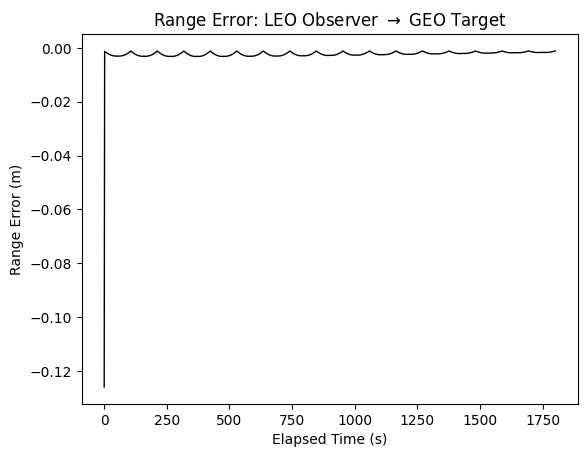

In [121]:
plot_range_error(results, 'LEO Observer', 'GEO Target', 'PMH8srwNZFTJ44rclH4VNB')

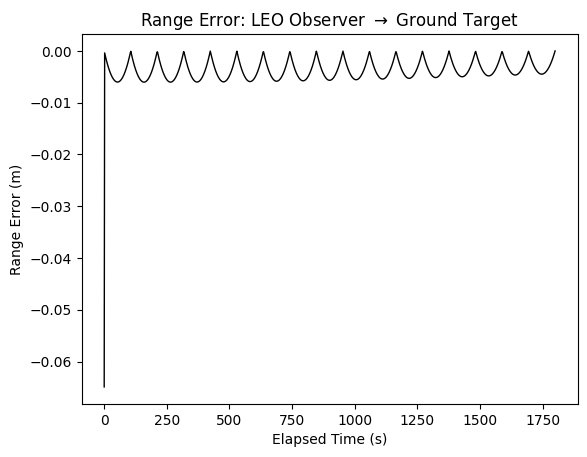

In [122]:
plot_range_error(results, 'LEO Observer', 'Ground Target', 'PMH8t46sJdTfdWjlNS3kK3')

### MEO Observer

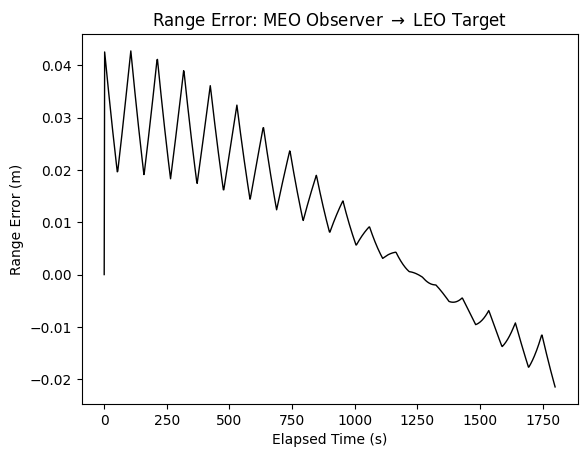

In [123]:
plot_range_error(results, 'MEO Observer', 'LEO Target', 'PMH8sdZ9PY4DmmRWwtvghy')

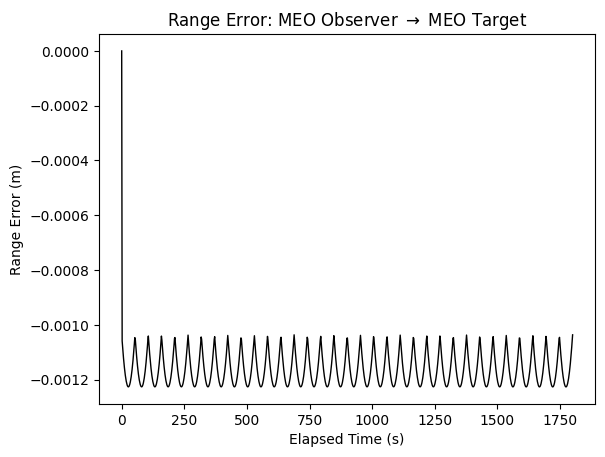

In [124]:
plot_range_error(results, 'MEO Observer', 'MEO Target', 'PMH8skzKNF6ZhJrlnlpNnz')

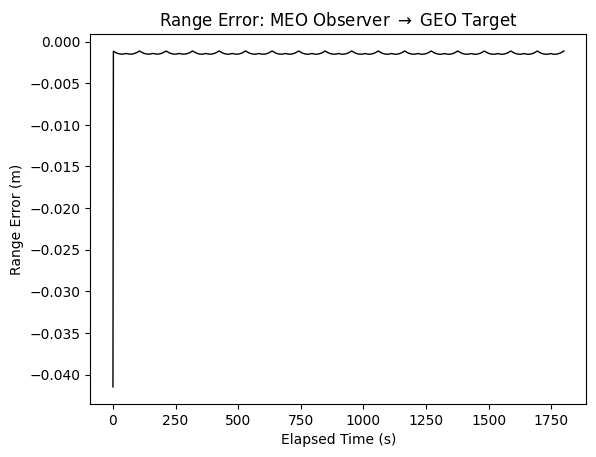

In [125]:
plot_range_error(results, 'MEO Observer', 'GEO Target', 'PMH8srwNZFTJ44rclH4VNB')

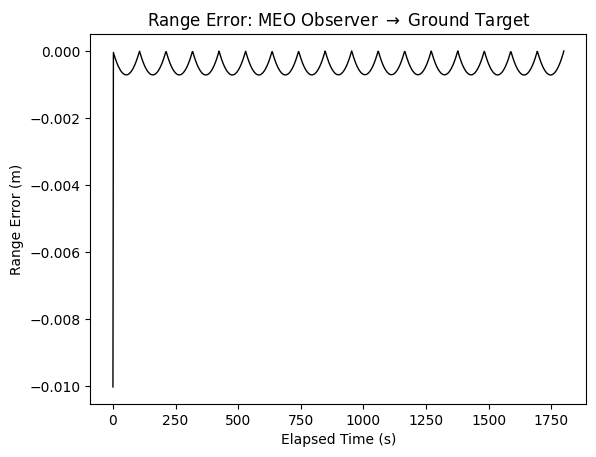

In [126]:
plot_range_error(results, 'MEO Observer', 'Ground Target', 'PMH8t46sJdTfdWjlNS3kK3')

### GEO Observer

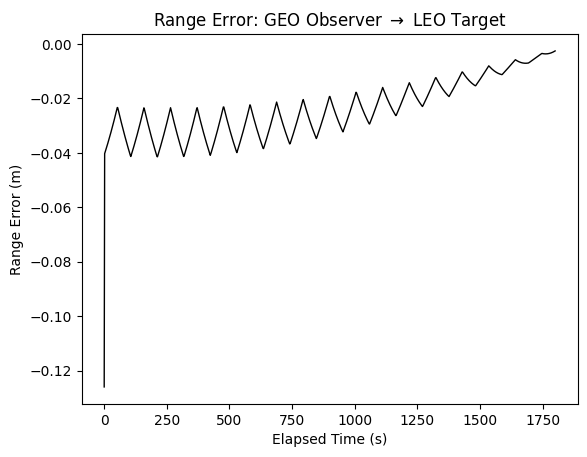

In [127]:
plot_range_error(results, 'GEO Observer', 'LEO Target', 'PMH8sdZ9PY4DmmRWwtvghy')

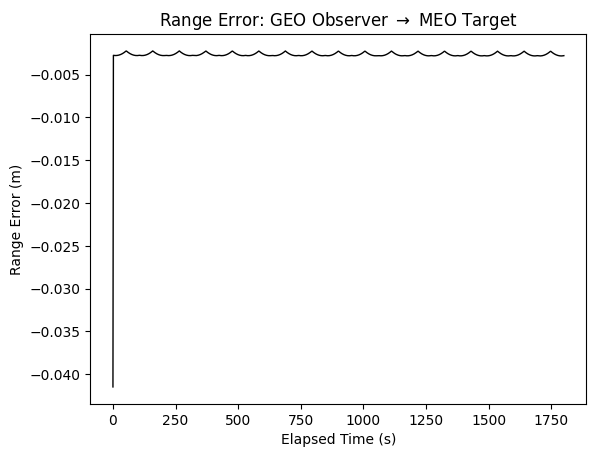

In [128]:
plot_range_error(results, 'GEO Observer', 'MEO Target', 'PMH8skzKNF6ZhJrlnlpNnz')

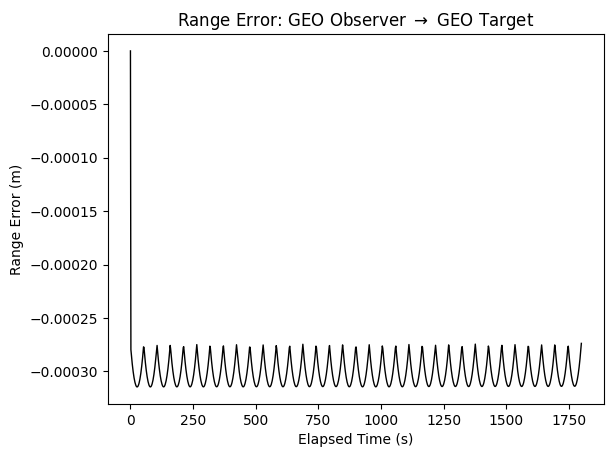

In [129]:
plot_range_error(results, 'GEO Observer', 'GEO Target', 'PMH8srwNZFTJ44rclH4VNB')

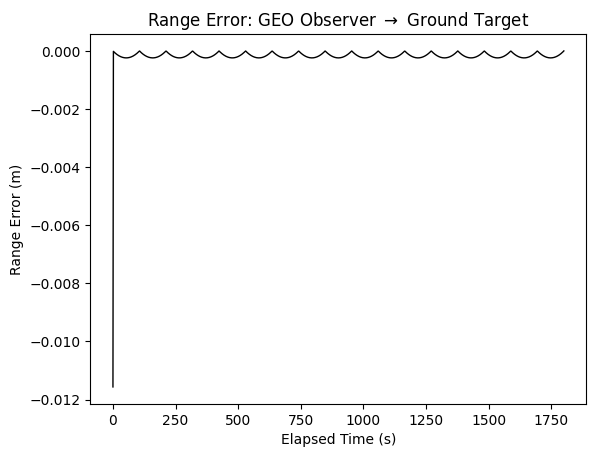

In [130]:
plot_range_error(results, 'GEO Observer', 'Ground Target', 'PMH8t46sJdTfdWjlNS3kK3')

### Ground Observer

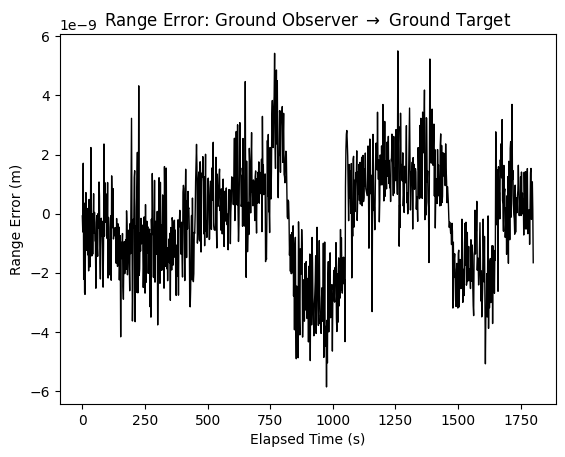

In [131]:
plot_range_error(results, 'Ground Observer', 'Ground Target', 'PMH9DHdtKyw89TvjpggCNt')

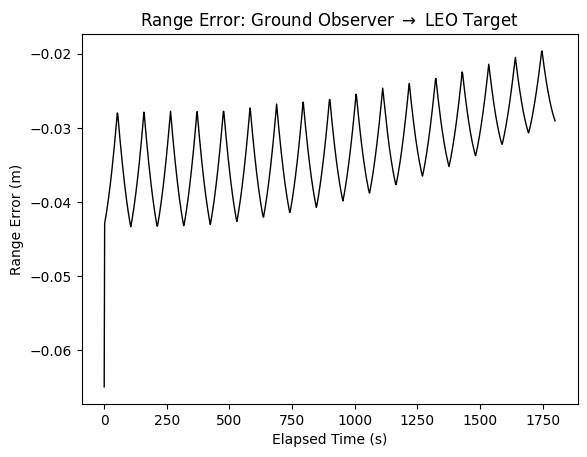

In [132]:
plot_range_error(results, 'Ground Observer', 'LEO Target', 'PMH9DMwndPxrW535KrS3Rp')

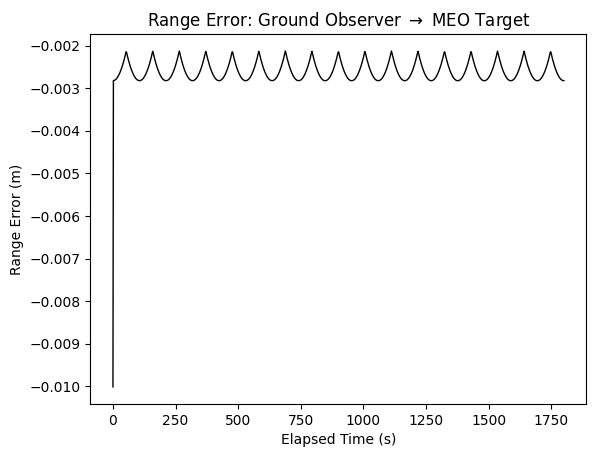

In [133]:
plot_range_error(results, 'Ground Observer', 'MEO Target', 'PMH9DTM827fBlmhL8CQCJr')

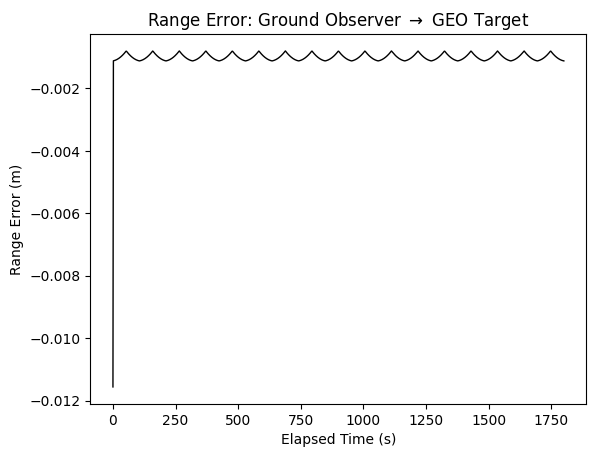

In [134]:
plot_range_error(results, 'Ground Observer', 'GEO Target', 'PMH9DZyVvcSDRQQnQVxd52')